<a href="https://colab.research.google.com/github/martinpius/tf_keras_training_loop_from_scratch/blob/main/Automatically_differentiation_more_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from google.colab import drive
try:
  drive.mount("/content/drive/", force_remount = True)
  COLAB = True
  import tensorflow as tf
  print(f"You are using tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print("---Please load your drive---")
def timefmt(t):
  h = int(t/ 60* 60)
  m = int(t % (60 * 60)/60)
  s = int(t % 60)
  return f"{h}:{m:>03}: {s:>05.2f}"

Mounted at /content/drive/
You are using tensorflow version: 2.3.0


In [73]:
timefmt(8.2034)

'8:000: 08.00'

In [74]:
#We can use tensorflow gradient tape to freeze some intermediate computation to compute derivatives of a more complex function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [75]:
x1 = tf.Variable(tf.constant([2.3,3.2,3.4], dtype = tf.float32))

In [76]:
x2 =tf.Variable(tf.constant([1.9,2.1,3.7], dtype= tf.float32))

In [77]:
with tf.GradientTape() as tape:
  x1s = x1*x1
  with tape.stop_recording(): #Freeze computation of the second slope
    x2s = x2*x2
  z = 1.378*x1s + 1.987*x2s

grads = tape.gradient(z, {'x1': x1,'x2':x2})
print(f"dx1 : {grads['x1']}, dx2: {grads['x2']}")


dx1 : [6.3388    8.8192005 9.3704   ], dx2: None


In [78]:
#We can also stop the gradient from flowing within a particular direction using tf.stop_gradient
x = tf.Variable(tf.constant([1.3,2.4,1.9,3.2], dtype = tf.float32))
y = tf.Variable(tf.constant([2.1,2.8,2.1,1.9], dtype  = tf.float32))

with tf.GradientTape() as tape:
  ys = tf.multiply(y,y)
  z = 3.6*x**3 +tf.stop_gradient(ys)#This stop operation on the 2nd part of the function
grad = tape.gradient(z, {'x':x, 'y':y})

display(grad)

{'x': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 18.251997,  62.207996,  38.987995, 110.592   ], dtype=float32)>,
 'y': None}

In [79]:
#We can also use a reset function to clean every previous records on the tape: (Its like a forget gate):
x = tf.Variable(tf.constant([2.0,4.3,2.9,4.0], dtype = tf.float32))
y = tf.Variable(tf.constant([3.2,3.2,1.4,4.2], dtype = tf.float32))

with tf.GradientTape() as tape:
  ys = tf.multiply(y, y)
  if True:
    tape.reset()#This will freeze information of ys in the tape
    xs = tf.multiply(x,x)
  z = 3.8*xs + 1.6*ys
grads = tape.gradient(z, {'x': x, 'y': y})

display(grads)

{'x': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([15.2 , 32.68, 22.04, 30.4 ], dtype=float32)>,
 'y': None}

In [80]:
#User defined gradient:
#There are multiple way to declare user's defined gradient computation
#we can use tf.RegisterGradient or tf.custom_gradient as decorators to customize the computations of our choice
#Ilustration of gradient cliping to prevent explossions using  tf.clip_by_norm
@tf.custom_gradient
def fn1(x):
  def fn2(mx):
    return tf.clip_by_norm(mx, 0.5)
  return x, fn2
x = tf.Variable(tf.constant([8,4], dtype = tf.float32))
with tf.GradientTape() as tape:
  out = fn1(x**2)
grads = tape.gradient(out, x)
display(grads)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.656854, 2.828427], dtype=float32)>

In [81]:
#High order derivatives with Nested Gradient tape
x = tf.Variable(2.)
with tf.GradientTape() as tape1:#For first derivative
  with tf.GradientTape() as tape2:#For second derivative
    y_c = x**3
  grad_1 = tape2.gradient(y_c, x)
grad_2 = tape1.gradient(grad_1, x)

display(grad_2)




<tf.Tensor: shape=(), dtype=float32, numpy=12.0>

In [82]:
p = tf.random.normal(shape =[10,16], mean = 3, stddev = 1.8)

In [83]:
#p

In [84]:
#Input gradient regularization for an adversarial example.
#Consider the following dense layer of a neural network (inputs-outputs relation)

dense_1 = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer='random_normal')

In [85]:
#Now we apply nested gradient tape to regularize the slope of the above layer's weights
with tf.GradientTape() as tape1:
  with tf.GradientTape(watch_accessed_variables = False) as tape2:
    q = dense_1(p)
    tape2.watch(p)#Freeze the input
    out = tf.reduce_sum(dense_1(p)**2)
  m1 = tape2.gradient(out, p)
  m1_norm = tf.norm(m1)#Regularization of the slope wrt out
m2 = tape1.gradient(m1,dense_1.trainable_variables)

#print(f"m1_shape: {m1}\nm2_shape: {m2}\nm1_norm: {m1_norm}")
[k.shape for k in m2]



[TensorShape([16, 128]), TensorShape([128])]

In [86]:
#The jacobian matrix of transformation can be obtained by tape method when we have vectors of values 
#This can be done depend on multiple shape of input-output
#We start with an example which yield vector of outputs 
x = tf.linspace(-1.0,1.0,100+1)
y = tf.Variable(0.0) #A place-holder like
with tf.GradientTape() as tape:
  z = tf.nn.sigmoid(x +y)# This is a target tensor which will determine the output shape too
J = tape.jacobian(z, y)

In [87]:
print(f"shape: {J.shape}\nout {J}")

shape: (101,)
out [0.19661194 0.19842187 0.20021665 0.20199534 0.20375688 0.20550032
 0.20722458 0.20892867 0.21061157 0.21227224 0.2139097  0.2155229
 0.21711081 0.21867248 0.22020683 0.22171287 0.22318965 0.22463612
 0.22605138 0.22743438 0.22878425 0.23009999 0.2313807  0.2326255
 0.23383345 0.23500372 0.23613545 0.2372278  0.23827998 0.2392912
 0.24026075 0.24118784 0.24207179 0.24291195 0.24370766 0.24445832
 0.24516332 0.24582215 0.24643427 0.24699923 0.24751657 0.24798588
 0.24840678 0.248779   0.24910218 0.24937606 0.24960044 0.24977514
 0.24990003 0.24997501 0.25       0.249975   0.24990003 0.24977514
 0.24960043 0.24937604 0.24910216 0.248779   0.2484068  0.24798588
 0.24751657 0.24699923 0.24643427 0.24582215 0.24516332 0.24445832
 0.24370766 0.24291196 0.2420718  0.24118784 0.24026075 0.23929122
 0.23827998 0.2372278  0.23613544 0.23500372 0.23383345 0.2326255
 0.2313807  0.23009999 0.22878425 0.22743441 0.22605138 0.22463612
 0.22318965 0.22171289 0.22020684 0.21867248 0.2

In [88]:
assert z.shape == J.shape #They must be of the same shape

In [89]:
x = tf.random.normal([5,5])
layer = tf.keras.layers.Dense(units = 16, kernel_initializer='random_normal', activation = 'relu')
out = layer(x)
assert out.shape == (5,16)


In [90]:
layer.kernel.shape

TensorShape([5, 16])

In [91]:
with tf.GradientTape() as tape:
  out = layer(x)
J = tape.jacobian(out, layer.kernel)

In [92]:
display(J.shape)

TensorShape([5, 16, 5, 16])

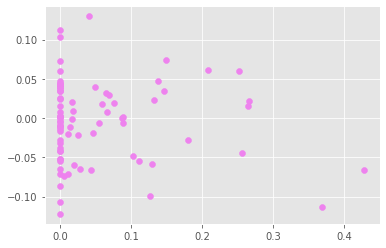

In [93]:
plt.style.use('ggplot')
plt.scatter(out.numpy(),layer.kernel.numpy(), color = 'violet')

In [107]:
#Batch jacobian. 
#Consider the following example
x = tf.random.normal([7,5])
layer1 = tf.keras.layers.Dense(units = 8, kernel_initializer = 'random_normal', activation = 'relu')
layer2 = tf.keras.layers.Dense(units = 6, kernel_initializer = 'random_normal', activation = 'relu')
with tf.GradientTape(watch_accessed_variables = False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)
J = tape.jacobian(y, x)
print(y.shape, J.shape)

(7, 6) (7, 6, 7, 5)


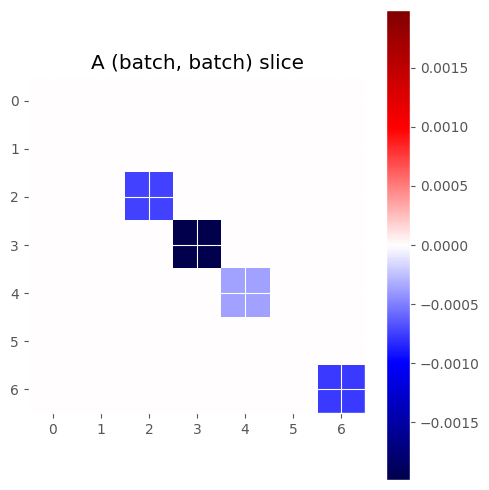

In [111]:
#The gradient has the shape (batch,*, batch, **)
#Slicing and ploting the results as an image pixels we get
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (5,5)
#mpl.rcParams['figure.dpi'] = 100
def display_std_img(img, **kwargs):
  '''This function plot the standardized arrays of numbers as pixels'''
  scales = tf.reduce_max(abs(img))
  #plt.style.use('ggplot')
  plt.imshow(img, vmin = -scales, vmax = scales, cmap = 'seismic', **kwargs)
  plt.colorbar()
  plt.tight_layout()


#slice_slope_batch = J[:,0,:,0]# This pick the diaganol elements (The density of the plot will display the same)
#display_std_img(slice_slope_batch)
display_std_img(J[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')
  
